In [47]:
using Polynomials, PyPlot, Interact

# The characteristic polynomial



# The perils of polynomial roots

In [40]:
w = prod([Poly([-n, 1.0]) for n = 1:10])

Poly(3.6288e6 - 1.062864e7*x + 1.2753576e7*x^2 - 8.4095e6*x^3 + 3.41693e6*x^4 - 902055.0*x^5 + 157773.0*x^6 - 18150.0*x^7 + 1320.0*x^8 - 55.0*x^9 + 1.0*x^10)

In [41]:
roots(w)

10-element Array{Float64,1}:
 10.0
  9.0
  8.0
  7.0
  6.0
  5.0
  4.0
  3.0
  2.0
  1.0

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(-6.5, nactions=1),"logR",-6.5,"-6.5",Interact.OptionDict(DataStructures.OrderedDict("-12.0"=>-12.0,"-11.9"=>-11.9,"-11.8"=>-11.8,"-11.7"=>-11.7,"-11.6"=>-11.6,"-11.5"=>-11.5,"-11.4"=>-11.4,"-11.3"=>-11.3,"-11.2"=>-11.2,"-11.1"=>-11.1…),Dict(-6.3=>"-6.3",-2.3=>"-2.3",-7.0=>"-7.0",-1.3=>"-1.3",-8.3=>"-8.3",-9.1=>"-9.1",-3.4=>"-3.4",-10.1=>"-10.1",-8.2=>"-8.2",-3.0=>"-3.0"…)),Any[],Any[],true,"horizontal")

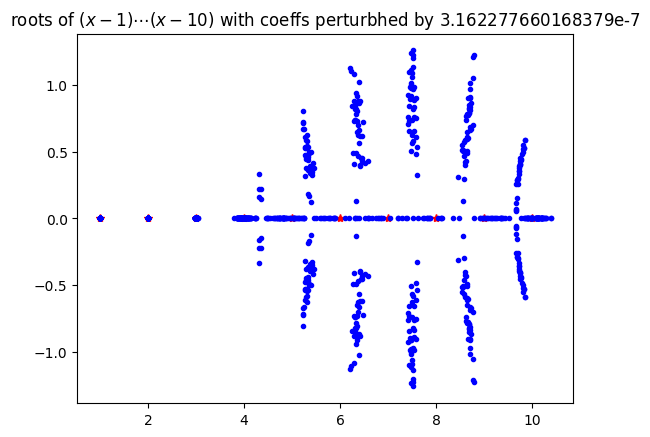

In [58]:
N = 10
w = prod([Poly([-n, 1.0]) for n = 1:N])
fig = figure()
@manipulate for logR in -12:0.1:-1
    withfig(fig) do
        plot(1:N, zeros(10), "r*")
        R = exp10(logR)
        for i = 1:100
            r = roots(Poly(coeffs(w) .* (1 .+ R .* randn(N+1))))
            plot(real(r), imag(r), "b.")
        end
        title("roots of \$(x-1)\\cdots(x-10)\$ with coeffs perturbhed by $R")
    end
end

# Companion matrices

Finding **roots of polynomials is *equivalent* to finding eigenvalues**.  Not only can you find eigenvalues by solving for the roots of the characteristic polynomial, but you can conversely find roots of *any* polynomial by turning into a matrix and finding the eigenvalues.

Given the degree-$n$ polynomial:

$$
p(z)=c_0 + c_1 z + \cdots + c_{n-1}z^{n-1} + z^n \;,
$$

(notice that the $z^n$ coefficient is 1), we define the **companion matrix**

$$
C=\begin{pmatrix}
0 & 0 & \dots & 0 & -c_0 \\
1 & 0 & \dots & 0 & -c_1 \\
0 & 1 & \dots & 0 & -c_2 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \dots & 1 & -c_{n-1}
\end{pmatrix}.
$$

The amazing fact is that the *characteristic polynomial* $\det (C - \lambda I) = p(\lambda)$, and so the **eigenvalues of C are the roots of p**.

If you have a polynomial whose leading coefficient is *not* 1, you can just divide the polynomial by that coefficient to get it in this form, without changing its roots.   Hence the **roots of any polynomial can be found by computing the eigenvalues of a companion matrix.**

In [71]:
function companion(p::Poly)
    c = coeffs(p)
    n = degree(p)
    c = c[1:n] / c[end]
    C = [ [ zeros(n-1)'; eye(n-1,n-1) ] -c ]
    return C
end

companion (generic function with 1 method)

In [72]:
p = Poly([-2, 1]) * Poly([-3, 1]) # (x - 2) * (x - 3)

Poly(6 - 5*x + x^2)

In [73]:
C = companion(p)

2×2 Array{Float64,2}:
 0.0  -6.0
 1.0   5.0

In [74]:
eigvals(C)

2-element Array{Float64,1}:
 2.0
 3.0

In [75]:
 # (x - 2) * (x - 3) * (x - 4) * (x + 1)
p = Poly([-2, 1]) * Poly([-3, 1]) * Poly([-4, 1]) * Poly([1, 1])

Poly(-24 + 2*x + 17*x^2 - 8*x^3 + x^4)

In [76]:
C = companion(p)

4×4 Array{Float64,2}:
 0.0  0.0  0.0   24.0
 1.0  0.0  0.0   -2.0
 0.0  1.0  0.0  -17.0
 0.0  0.0  1.0    8.0

In [77]:
eigvals(C)

4-element Array{Float64,1}:
 -1.0
  2.0
  3.0
  4.0

In fact, **this is the most common method to find roots of polynomials of degree > 5**: you find the companion matrix, and compute its eigenvalues.  This is precisely how the Polynomials package does it (albeit with some extra cleverness to check for leading and trailing zero coefficients):

In [79]:
@which roots(p)

roots{T}(p::Polynomials.Poly{T}) at /Users/stevenj/.julia/v0.5/Polynomials/src/Polynomials.jl:621

This would seem rather circular if eigenvalues were computed, in turn, by finding roots of polynomials.  But they aren't: **practical computer eigenvalue solvers never compute the characteristic polynomial, and don't resemble generic root-finding algorithms (like Newton's method)**.

# Computing eigenvalues = polynomial roots = hard

* Everyone learns the [quadratic formula](https://en.wikipedia.org/wiki/Quadratic_formula) to find roots of a quadratic (degree-2) polynomial.

* There is a (horrible) [cubic formula](https://en.wikipedia.org/wiki/Cubic_function) to find the roots of any cubic (degree-3) polynomial.

* There is a (terrifying) [quartic formula](https://en.wikipedia.org/wiki/Quartic_function) to find the roots of any quartic (degree-4) polynomial.

* There is **no formula** (in terms of a *finite number* of ±,×,÷,ⁿ√) for the roots of an **arbitrary quintic** polynomial or **any degree ≥ 5**.  This is the [Abel–Ruffini theorem](https://en.wikipedia.org/wiki/Abel%E2%80%93Ruffini_theorem), proved in the 19th century.

This does **not mean** that you can't compute roots (or eigenvalues) in practice!  But it means that **root-finding/eigenvalue algorithms are necessarily *iterative***: they **converge toward the solution** but **never reach it exactly**.  You can get the solution to *any desired accuracy*.

For example we've already seen one such algorithm!  [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) is an algorithm that could be used to find the roots of an arbitrary polynomial (given enough starting guesses), and converges *very* quickly without ever exactly *reaching* the root.

The most common algorithm to find eigenvalues (and hence polynomial roots, via companion matrices) is the [QR algorithm](https://en.wikipedia.org/wiki/QR_algorithm).  As you might guess, it is *related* to the $A=QR$ factorization.  Explaining *how* and *why* this algorithm works, however, is outside the scope of 18.06.  (It takes me a week+ in 18.335: graduate numerical methods.)

This means that the textbook characteristic-polynomial method we use to find eigenvalues of $2\times 2$ matrices is something of a fraud: unlike Gaussian elimination, it bears no resemblance whatsoever to how eigenvalues are really computed.  In 18.06, therefore, we will mostly assume that the computer hands us the eigenvalues and eigenvectors, and **we will focus on what eigensolutions *mean*, how they are *used*, and what their *properties* are.**